# 4. Finding meaning in word counts (semantic analysis)

### 4.1.3 Thought experiment

In [1]:
topic = {}
tfidf = dict(list(zip('cat dog apple lion NYC love'.split(), [1, 1, 1, 1, 1, 1])))
topic['pet'] = (.3 * tfidf['cat'] + .3 * tfidf['dog'] + 0 * tfidf['apple']
                + 0 * tfidf['lion'] - .2 * tfidf['NYC'] + .2 * tfidf['love'])
topic['animal'] = (.1 * tfidf['cat'] + .1 * tfidf['dog'] - .1 * tfidf['apple']
                   + .5 * tfidf['lion'] + .1 * tfidf['NYC'] - .1 * tfidf['love'])
topic['city'] = (0 * tfidf['cat'] - .1 * tfidf['dog'] + .2 * tfidf['apple']
                 - .1 * tfidf['lion'] + .5 * tfidf['NYC'] + .1 * tfidf['love'])

topic

{'pet': 0.6, 'animal': 0.6, 'city': 0.6}

In [2]:
word_vector = {}
word_vector['cat'] = .3 * topic['pet'] + .1 * topic['animal'] + 0 * topic['city']
word_vector['dog'] = .3 * topic['pet'] + .1 * topic['animal'] - .1 * topic['city']
word_vector['apple'] = 0 * topic['pet'] - .1 * topic['animal'] + .2 * topic['city']
word_vector['lion'] = 0 * topic['pet'] + .5 * topic['animal'] - .1 * topic['city']
word_vector['NYC'] = -.2 * topic['pet'] + .1 * topic['animal'] + .5 * topic['city']
word_vector['love'] = .2 * topic['pet'] - .1 * topic['animal'] + .1 * topic['city']

word_vector

{'cat': 0.24,
 'dog': 0.18,
 'apple': 0.06,
 'lion': 0.24,
 'NYC': 0.24,
 'love': 0.12}

### 4.1.5 An LDA classifier

In [4]:
!pip install ipdb

  Preparing metadata (setup.py) ... done
  Created wheel for ipdb: filename=ipdb-0.13.9-py3-none-any.whl size=11648 sha256=0b16f87e3014d428d379a5190f6a55d7434e1744ed74330badac2c6252334447
  Stored in directory: /home/jovyan/.cache/pip/wheels/f7/29/9a/cf774cd86e9802f075a0be1c9e0830bc062d07897b2e9e87cd
Successfully built ipdb


In [5]:
import pandas as pd
from nlpia.data.loaders import get_data
pd.options.display.width = 120  # <1>

sms = get_data('sms-spam')
index = ['sms{}{}'.format(i, '!'*j) for (i,j) in zip(range(len(sms)), sms.spam)]  # <2>
sms = pd.DataFrame(sms.values, columns=sms.columns, index=index)
mask = sms.spam.astype(bool).values
sms['spam'] = sms.spam.astype(int)

len(sms)

Loading file with name: sms-spam


/home/jovyan/nlpia/src/nlpia/loaders.py:79: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  np = pd.np


4837

In [6]:
sms.spam.sum()

638

In [7]:
sms.head(6)

,spam,text
sms0,0,"Go until jurong point, crazy.. Available only ..."
sms1,0,Ok lar... Joking wif u oni...
sms2!,1,Free entry in 2 a wkly comp to win FA Cup fina...
sms3,0,U dun say so early hor... U c already then say...
sms4,0,"Nah I don't think he goes to usf, he lives aro..."
sms5!,1,FreeMsg Hey there darling it's been 3 week's n...


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs = tfidf_model.fit_transform(raw_documents=sms.text).toarray()

tfidf_docs.shape

(4837, 9232)

In [9]:
mask = sms.spam.astype(bool).values  # <1>
spam_centroid = tfidf_docs[mask].mean(axis=0) # <2>
ham_centroid = tfidf_docs[~mask].mean(axis=0)

spam_centroid.round(2), ham_centroid.round(2)

(array([0.06, 0.  , 0.  , ..., 0.  , 0.  , 0.  ]),
 array([0.02, 0.01, 0.  , ..., 0.  , 0.  , 0.  ]))

In [11]:
spamminess_score = tfidf_docs.dot(spam_centroid - ham_centroid)
spamminess_score.round(2)

array([-0.01, -0.02,  0.04, ..., -0.01, -0.  ,  0.  ])

In [12]:
from sklearn.preprocessing import MinMaxScaler
sms['lda_score'] = MinMaxScaler().fit_transform(spamminess_score.reshape(-1,1))
sms['lda_predict'] = (sms.lda_score > .5).astype(int)

sms['spam lda_predict lda_score'.split()].round(2).head(6)

,spam,lda_predict,lda_score
sms0,0,0,0.23
sms1,0,0,0.18
sms2!,1,1,0.72
sms3,0,0,0.18
sms4,0,0,0.29
sms5!,1,1,0.55


In [13]:
(1. - (sms.spam - sms.lda_predict).abs().sum() / len(sms)).round(3)

0.977

In [14]:
from pugnlp.stats import Confusion

Confusion(sms['spam lda_predict'.split()])

/opt/conda/lib/python3.9/site-packages/pugnlp/stats.py:504: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.__setattr__('_hist_labels', self.sum().astype(int))
/opt/conda/lib/python3.9/site-packages/pugnlp/stats.py:510: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  setattr(self, '_hist_classes', self.T.sum())
/opt/conda/lib/python3.9/site-packages/pugnlp/stats.py:513: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  setattr(self, '_tp', self.get(self._pos_label, pd.Series()).get(self._pos_label, 0))
/opt/conda/lib/python3.9/site-packages/pugnlp/stats.py:517: FutureWarning: The default dtype for empty Series will be 'object' instead of 'f

lda_predict,0,1
spam,,
0,4135,64
1,45,593


### 4.2.1 Your thought experiment made real

In [15]:
from nlpia.book.examples.ch04_catdog_lsa_3x6x16\
    import word_topic_vectors
word_topic_vectors.T.round(1)

Loading file with name: cats_and_dogs_sorted


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 198471.02it/s]


,cat,dog,apple,lion,nyc,love
top0,-0.6,-0.4,0.5,-0.3,0.4,-0.1
top1,-0.1,-0.3,-0.4,-0.1,0.1,0.8
top2,-0.3,0.8,-0.1,-0.5,0.0,0.1


## 4.3 Singular value decomposition

In [16]:
from nlpia.book.examples.ch04_catdog_lsa_sorted import lsa_models, prettify_tdm

bow_svd, tfidf_svd = lsa_models()  # <1>
prettify_tdm(**bow_svd)

Loading file with name: cats_and_dogs_sorted


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 314812.20it/s]


Loading file with name: cats_and_dogs_sorted


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 339729.58it/s]


,cat,dog,apple,lion,nyc,love,text
0,,,1,,1,,NYC is the Big Apple.
1,,,1,,1,,NYC is known as the Big Apple.
2,,,,,1,1,I love NYC!
3,,,1,,1,,I wore a hat to the Big Apple party in NYC.
4,,,1,,1,,Come to NYC. See the Big Apple!
5,,,1,,,,Manhattan is called the Big Apple.
6,1,,,,,,New York is a big city for a small cat.
7,1,,,1,,,"The lion, a big cat, is the king of the jungle."
8,1,,,,,1,I love my pet cat.
9,,,,,1,1,I love New York City (NYC).


In [17]:
tdm = bow_svd['tdm'] 
tdm

,0,1,2,3,4,5,6,7,8,9,10
cat,0,0,0,0,0,0,1,1,1,0,1
dog,0,0,0,0,0,0,0,0,0,0,1
apple,1,1,0,1,1,1,0,0,0,0,0
lion,0,0,0,0,0,0,0,1,0,0,0
nyc,1,1,1,1,1,0,0,0,0,1,0
love,0,0,1,0,0,0,0,0,1,1,0


### 4.3.1 U--left singular vectors

In [18]:
import numpy as np
import pandas as pd

u, s, vt = np.linalg.svd(tdm)
pd.DataFrame(u, index=tdm.index).round(2)

,0,1,2,3,4,5
cat,-0.04,0.83,-0.38,-0.00,0.11,-0.38
dog,-0.00,0.21,-0.18,-0.71,-0.39,0.52
apple,-0.62,-0.21,-0.51,0.00,0.49,0.27
lion,-0.00,0.21,-0.18,0.71,-0.39,0.52
nyc,-0.75,-0.00,0.24,-0.00,-0.52,-0.32
love,-0.22,0.42,0.69,0.00,0.41,0.37


### 4.3.2 S--singular vectors

In [19]:
s.round(1)

array([3.1, 2.2, 1.8, 1. , 0.8, 0.5])

In [22]:
S = np.zeros((len(u), len(vt)))
pd.np.fill_diagonal(S, s)
pd.DataFrame(S).round(1)

/tmp/ipykernel_141/4097854748.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  pd.np.fill_diagonal(S, s)


,0,1,2,3,4,5,6,7,8,9,10
0,3.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0


### 4.3.3 V<sup>t</sup>--right singular values

In [23]:
pd.DataFrame(vt).round(2)

,0,1,2,3,4,5,6,7,8,9,10
0,-0.44,-0.44,-0.31,-0.44,-0.44,-0.20,-0.01,-0.01,-0.08,-0.31,-0.01
1,-0.09,-0.09,0.19,-0.09,-0.09,-0.09,0.37,0.47,0.56,0.19,0.47
2,-0.16,-0.16,0.52,-0.16,-0.16,-0.29,-0.22,-0.32,0.17,0.52,-0.32
3,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.71,0.00,-0.00,-0.71
4,-0.04,-0.04,-0.14,-0.04,-0.04,0.58,0.13,-0.33,0.62,-0.14,-0.33
5,-0.09,-0.09,0.10,-0.09,-0.09,0.51,-0.73,0.27,-0.01,0.10,0.27
6,-0.57,0.21,0.11,0.33,-0.31,0.34,0.34,0.00,-0.34,0.23,0.00
7,-0.32,0.47,0.25,-0.63,0.41,0.07,0.07,0.00,-0.07,-0.18,0.00
8,-0.50,0.29,-0.20,0.41,0.16,-0.37,-0.37,-0.00,0.37,-0.17,0.00
9,-0.15,-0.15,-0.59,-0.15,0.42,0.04,0.04,-0.00,-0.04,0.63,-0.00


### 4.3.5 Truncating the topics

In [25]:
err = []
for numdim in range(len(s), 0, -1):
    S[numdim - 1, numdim - 1] = 0
    reconstructed_tdm = u.dot(S).dot(vt)
    err.append(np.sqrt(((\
                         reconstructed_tdm - tdm).values.flatten() ** 2).sum()
                       / np.product(tdm.shape)))

np.array(err).round(2)

array([0.06, 0.12, 0.17, 0.28, 0.39, 0.55])

[0.06422633791023077, 0.12203397231758811, 0.17333149036203727, 0.27859482227696736, 0.39162820475179105, 0.5504818825631803]


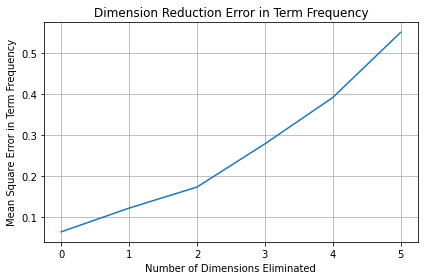

In [27]:
from matplotlib import pyplot as plt

plt.plot(range(len(err)), err)
plt.title('Dimension Reduction Error in Term Frequency')
plt.xlabel('Number of Dimensions Eliminated')
plt.ylabel('Mean Square Error in Term Frequency')
plt.grid('on')
plt.tight_layout()
print(err)
# plt.show()

### 4.4.1 PCA on 3D vectors